# Smooth throughput in 2023

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : July 26th 2023
- update : July 27th 2023

** Kernel anaconda3_auxtel**

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.patches import Rectangle

In [2]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.optimize import curve_fit
from scipy.odr import Model,ODR,RealData
from scipy import linalg

In [3]:
from functools import reduce

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/6cf2109gm_tmc.fits',
 'thermtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/6cf2109gm_tmc.fits',
 'thermtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [6]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [7]:
path_calspec = os.path.join(os.getenv("PYSYN_CDBS"),"calspec")
   
dict_sedfilename = {'HD38666': "mucol_stis_005.fits", 
                    'HD42525': "eta1dor_stis_004.fits",
            'HD185975': "hd185975_stis_003.fits",
            'HD074000': "hd074000_stis_003.fits",
            'HD60753' : "hd60753_stis_003.fits",
            'HD111980': "hd111980_stis_003.fits",
            'HD37962':  "hd37962_stis_005.fits",
            'HD031128' : "hd031128_stis_005.fits",
            'HD14943' : "hd14943_stis_005.fits",
            'HD38949' : "hd38949_stis_005.fits",
            'HD60753' : "hd60753_stis_004.fits",
             'HD200654': "hd200654_stis_006.fits",  
             'HD115169': "hd115169_stis_003.fits",
             'HD142331': "hd142331_stis_004.fits", 
             'HD167060': "hd167060_stis_004.fits", 
            'HD146233': "18sco_stis_004.fits"       
              }   

In [8]:
dict_absbands = {} 
dict_absbands["O3"] = (560.,640.,0)
dict_absbands["O2_1"] = (685.,695.,1)
dict_absbands["O2_2"] = (760.,770.,1)
dict_absbands["H2O_1"] = (715.,735.,2)
dict_absbands["H2O_2"] = (815.,835.,2)
dict_absbands["H2O_3"] = (925.,980.,2)
absbands_colors = ['yellow','cyan','green']

## Config

In [9]:
!ls dataout

MLfit_bouguer_linearfit-2023-01-17-rebin1-HD38666.csv
MLfit_bouguer_linearfit-2023-01-17-rebin2-HD38666.csv
MLfit_bouguer_linearfit-2023-01-18-rebin1-HD38666.csv
MLfit_bouguer_linearfit-2023-01-18-rebin2-HD38666.csv
MLfit_bouguer_linearfit-2023-01-19-rebin1-HD42525.csv
MLfit_bouguer_linearfit-2023-01-19-rebin2-HD42525.csv
MLfit_bouguer_linearfitsmoothGP-2023-January-17-18-mucol.csv
MLfit_bouguer_linearfitsmoothGPsmoothGP-absbadremoved-2023-January-17-18-mucol.csv


In [10]:
DATE = "2023-January-17-18"
FILTERTYPE = "empty~holo4_003"
SITE = "AUXTEL"
spectractormode = "psf2dffm"
FLAG_POLAR = False
target = "mucol"
filenames = [ "dataout/MLfit_bouguer_linearfit-2023-01-17-rebin1-HD38666.csv",  
              "dataout/MLfit_bouguer_linearfit-2023-01-17-rebin2-HD38666.csv",
             "dataout/MLfit_bouguer_linearfit-2023-01-18-rebin1-HD38666.csv",  
              "dataout/MLfit_bouguer_linearfit-2023-01-18-rebin2-HD38666.csv",]

tags = ["2023-01-17 (rebin1)", "2023-01-17 (rebin2)","2023-01-18 (rebin1)","2023-01-18 (rebin2)"]
outputfile_linearfit = "MLfit-bouguer-througpfit-HD38666-"

In [11]:
WLMINSEL = 350.
WLMAXSEL = 1025
WL= np.arange(WLMINSEL,WLMAXSEL)

## Initialisation

### Initialisation of SED

In [12]:
dict_f_sed = {}
dict_name_sed = {}

In [13]:
for targetid, sedfilename in dict_sedfilename.items():
    print(targetid, '->', sedfilename)
    s0=S.FileSpectrum(os.path.join(path_calspec,sedfilename))
    
    the_targetname = s0.fheader['TARGETID']
    
    sed_w=s0.wave/10
    sed_f=s0.flux*10
    sed_idx=np.where(np.logical_and(sed_w> WLMINSEL ,sed_w< WLMAXSEL))[0]
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
    dict_name_sed[targetid] = the_targetname
    dict_f_sed[targetid] = f_sed 


HD38666 -> mucol_stis_005.fits
HD42525 -> eta1dor_stis_004.fits
HD185975 -> hd185975_stis_003.fits
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
HD074000 -> hd074000_stis_003.fits
HD60753 -> hd60753_stis_004.fits
HD111980 -> hd111980_stis_003.fits
HD37962 -> hd37962_stis_005.fits
Warning, 26 of 6260 bins contained negative fluxes; they have been set to zero.
HD031128 -> hd031128_stis_005.fits
Warning, 1 of 6256 bins contained negative fluxes; they have been set to zero.
HD14943 -> hd14943_stis_005.fits
Warning, 34 of 7206 bins contained negative fluxes; they have been set to zero.
HD38949 -> hd38949_stis_005.fits
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
HD200654 -> hd200654_stis_006.fits
HD115169 -> hd115169_stis_003.fits
Warning, 70 of 6817 bins contained negative fluxes; they have been set to zero.
HD142331 -> hd142331_stis_004.fits
Warning, 67 of 6816 bins contained negative fluxes; they have been set to zero.
H

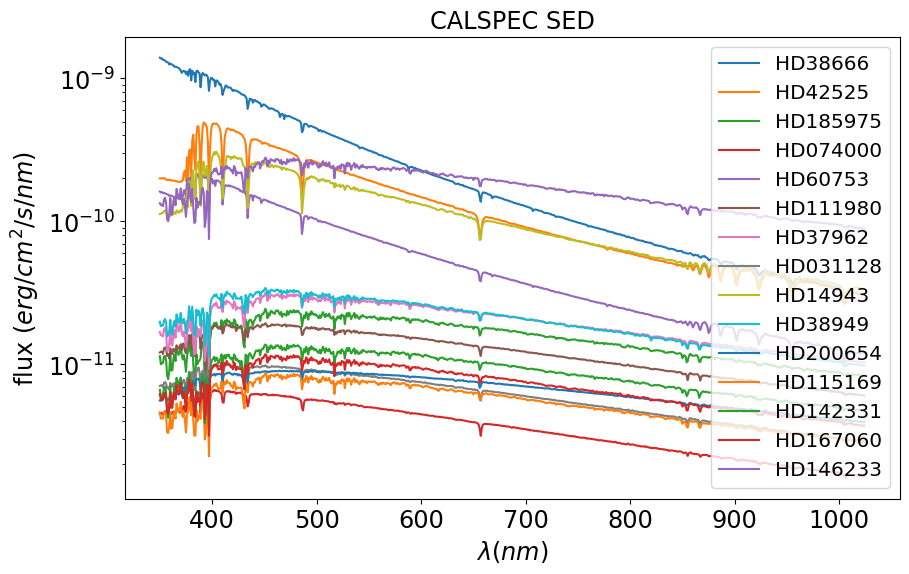

In [14]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WL)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WL,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

## Read file

In [15]:
all_df = []

for filename in filenames:
    df = pd.read_csv(filename,index_col=0)
    all_df.append(df) 

In [16]:
df.head()

,wavelength,throu,errthrou,sedtoa,errsedtoa
0,355.000000,0.010665,0.001086,6.560674e-12,6.682153e-13
1,368.673469,0.014989,0.000996,1.674250e-11,1.112118e-12
2,382.346939,0.029954,0.001485,3.216374e-11,1.594029e-12
3,396.020408,0.050660,0.001943,5.009912e-11,1.921645e-12
4,409.693878,0.065662,0.001812,5.856081e-11,1.616275e-12


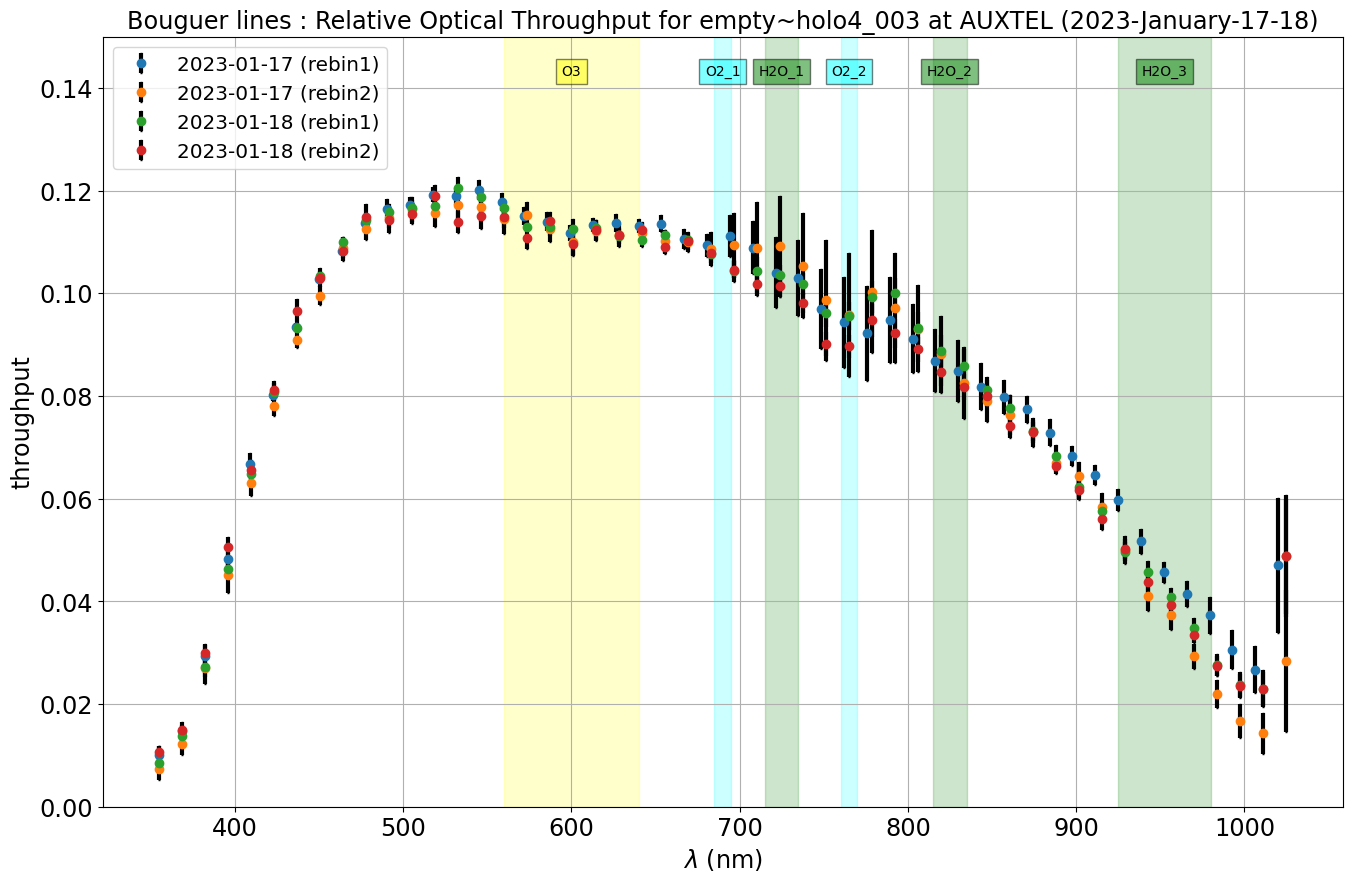

In [17]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)


for idx,df1 in enumerate(all_df):
    
    X1=df1["wavelength"].values
    Y1=df1["throu"].values
    EY1= df1["errthrou"].values


    if idx==1:
        ax.errorbar(X1,Y1, yerr=EY1, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx],alpha=1)
    else:
        ax.errorbar(X1,Y1, yerr=EY1, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx])

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput for {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()

the_ymin=0
the_ymax = 0.15
the_yscale = the_ymax-the_ymin

ax.set_ylim(the_ymin,the_ymax)

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    the_x = (val[0]+val[1])/2.
    the_y = the_ymax - 0.05* the_yscale
    rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
    ax.add_patch(rect)
    ax.text(the_x, the_y, key, horizontalalignment='center',bbox=dict(facecolor=absbands_colors[idx_abscolor], alpha=0.5))

        

ax.legend()
        

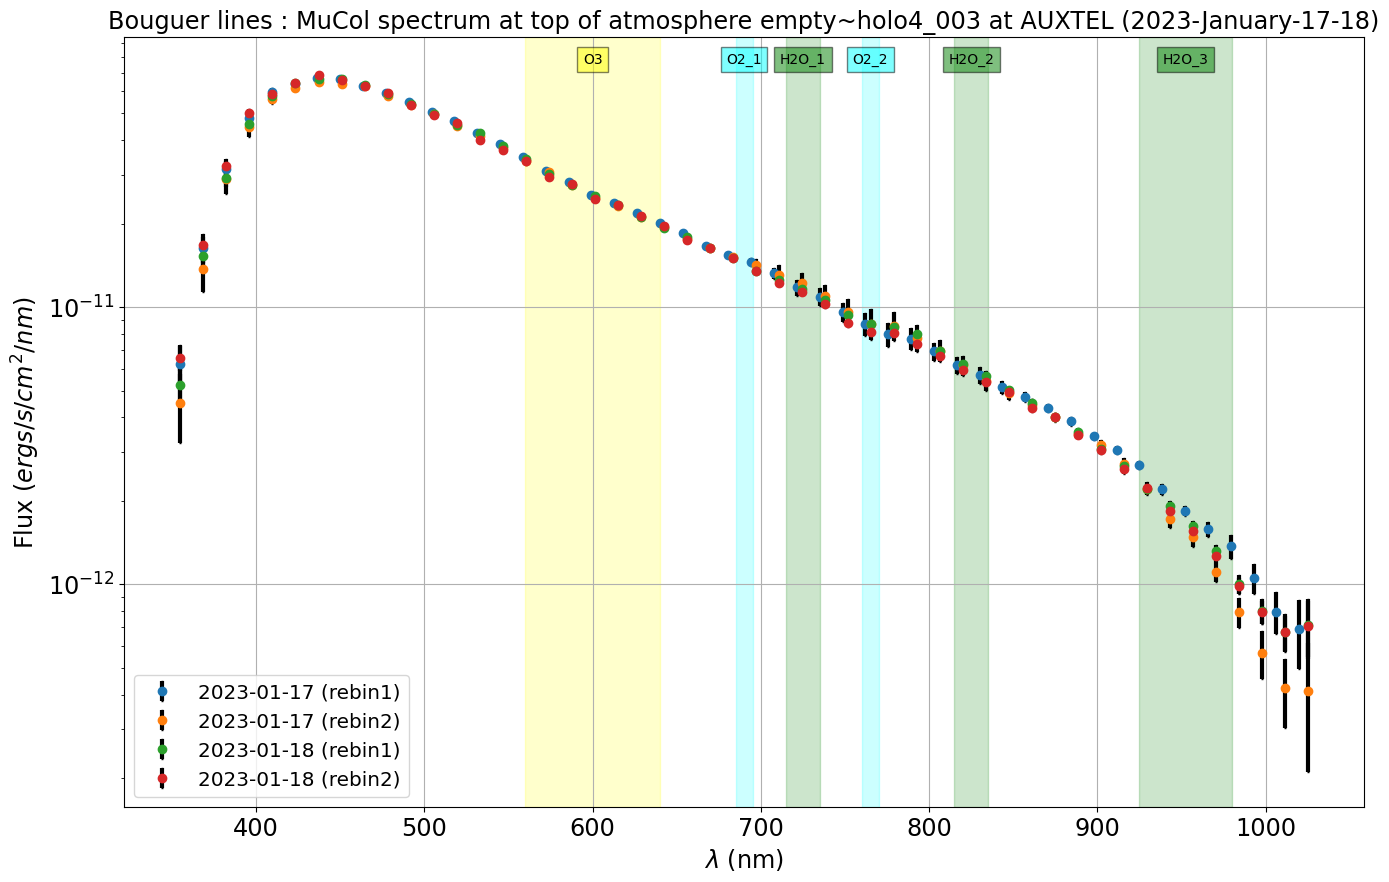

In [18]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)


for idx,df1 in enumerate(all_df):
    
    X1=df1["wavelength"].values
    Y1=df1["sedtoa"].values
    EY1= df1["errsedtoa"].values


    if idx==1:
        ax.errorbar(X1,Y1, yerr=EY1, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx],alpha=1)
    else:
        ax.errorbar(X1,Y1, yerr=EY1, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx])

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("Flux ($ergs/s/cm^2/nm$)")
title=f"Bouguer lines : MuCol spectrum at top of atmosphere {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
#ax.set_ylim(0,0.2)
ax.set_yscale('log')

the_ymin,the_ymax = ax.get_ylim()
the_yscale = the_ymax-the_ymin

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    the_x = (val[0]+val[1])/2.
    the_y = the_ymax - 0.2* the_yscale
    rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
    ax.add_patch(rect)
    ax.text(the_x, the_y, key, horizontalalignment='center',bbox=dict(facecolor=absbands_colors[idx_abscolor], alpha=0.5))




In [19]:
f_sed =  dict_f_sed['HD38666']

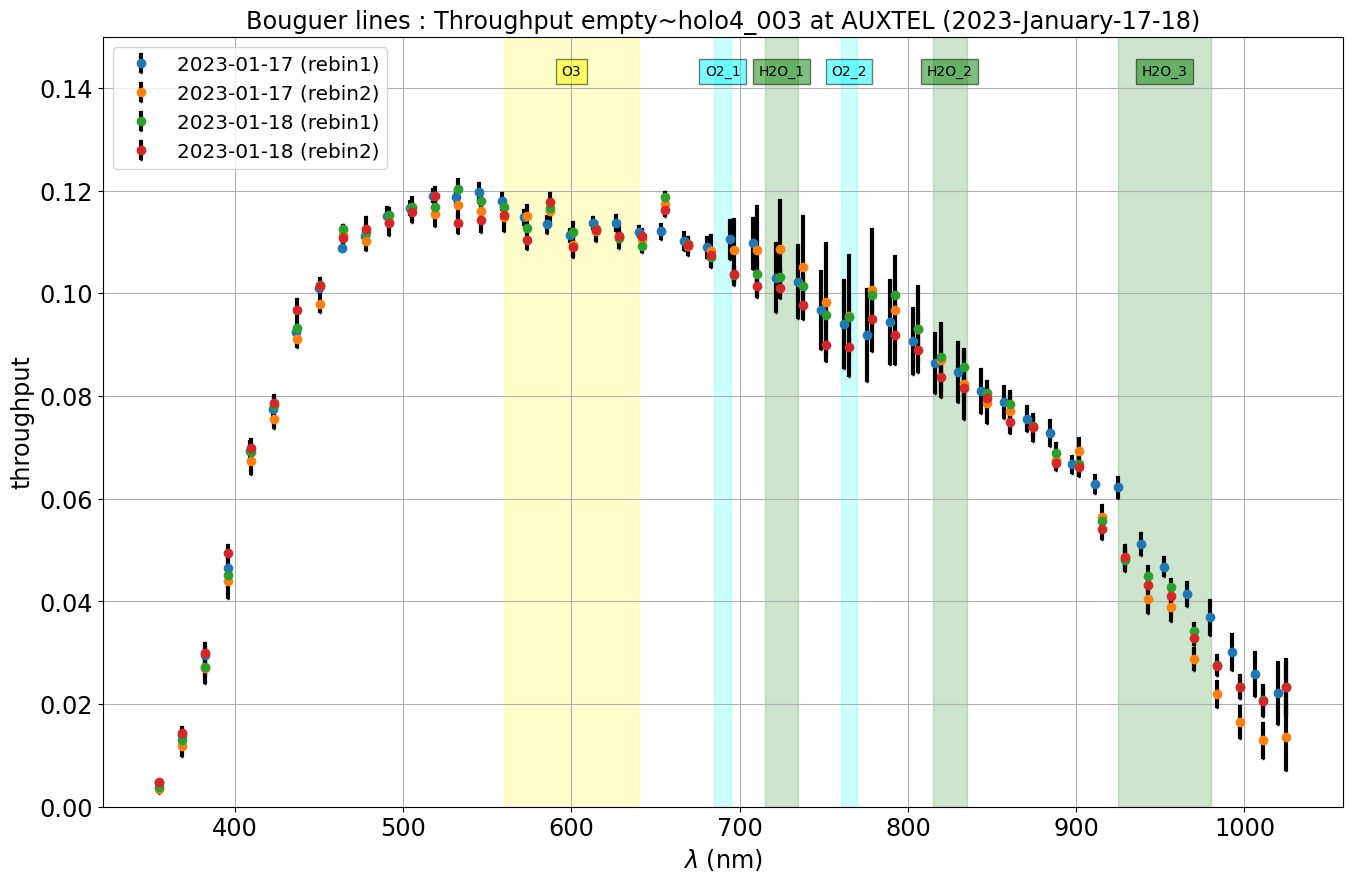

In [20]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)


for idx,df1 in enumerate(all_df):
    
    X1=df1["wavelength"].values
    Y1=df1["sedtoa"].values
    EY1= df1["errsedtoa"].values
    
    Y2 = Y1/f_sed(X1)
    EY2 = EY1/f_sed(X1)

    if idx==1:
        ax.errorbar(X1,Y2, yerr=EY2, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx],alpha=1)
    else:
        ax.errorbar(X1,Y2, yerr=EY2, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx])

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Throughput {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
the_ymin=0
the_ymax = 0.15
ax.set_ylim(the_ymin,the_ymax)

the_yscale = the_ymax-the_ymin

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    the_x = (val[0]+val[1])/2.
    the_y = the_ymax - 0.05* the_yscale
    rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
    ax.add_patch(rect)
    ax.text(the_x, the_y, key, horizontalalignment='center',bbox=dict(facecolor=absbands_colors[idx_abscolor], alpha=0.5))


  


# Merge all data

In [21]:
X = np.array([])
Y = np.array([])
EY = np.array([])

for idx,df in enumerate(all_df):
    
    X1 =df["wavelength"].values
    Y1 =df["throu"].values
    EY1 = df["errthrou"].values
    X  = np.append(X, X1)
    Y  = np.append(Y, Y1)
    EY  = np.append(EY, EY1)

In [22]:
sorted_indexes = np.argsort(X)
X = X[sorted_indexes]
Y = Y[sorted_indexes]
EY = EY[sorted_indexes]

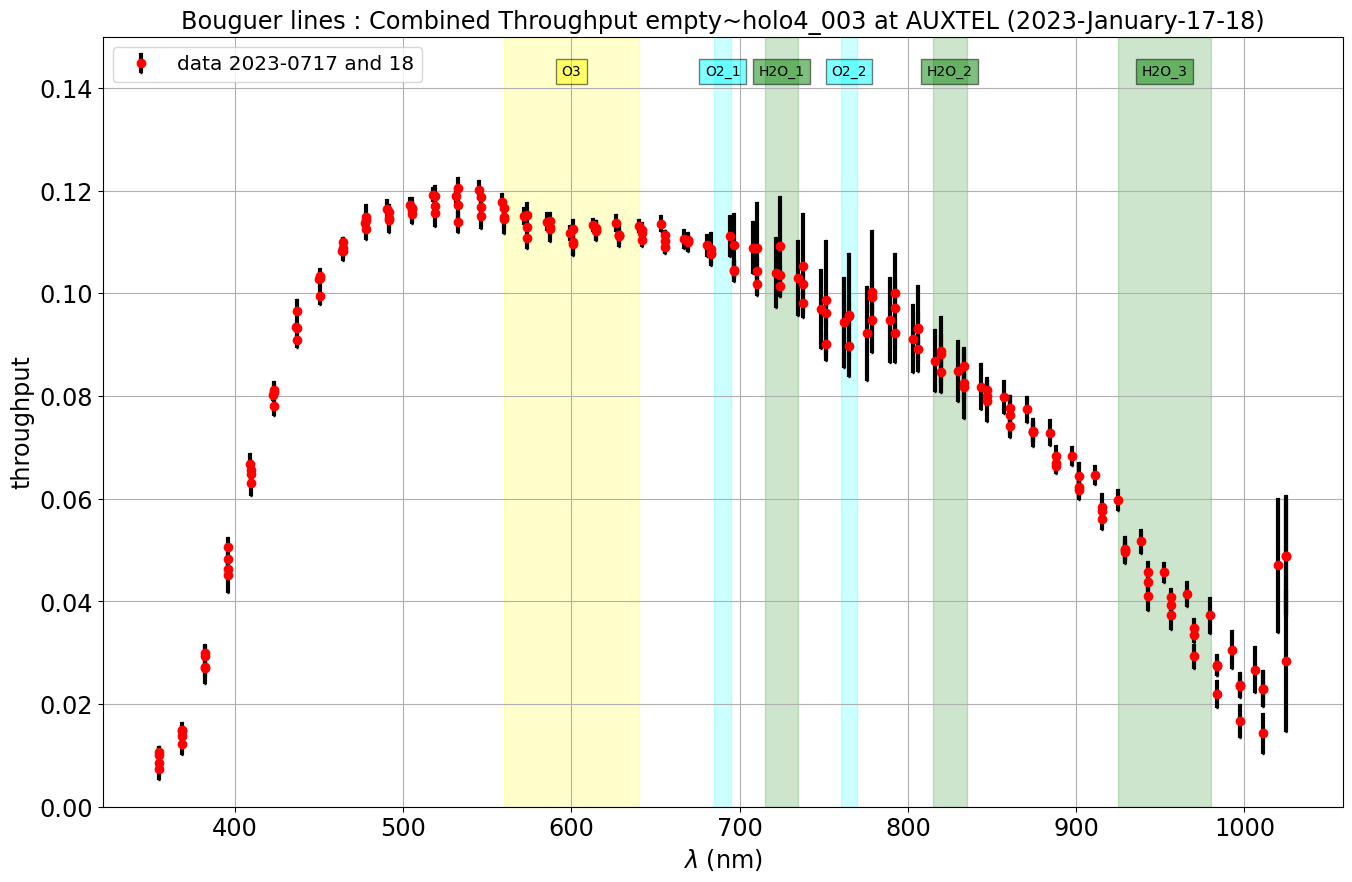

In [23]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="red",ecolor="k", elinewidth=3, capsize=1,alpha=1,label="data 2023-0717 and 18")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Combined Throughput {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
the_ymin=0
the_ymax = 0.15
ax.set_ylim(the_ymin,the_ymax)

the_yscale = the_ymax-the_ymin

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    the_x = (val[0]+val[1])/2.
    the_y = the_ymax - 0.05* the_yscale
    rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
    ax.add_patch(rect)
    ax.text(the_x, the_y, key, horizontalalignment='center',bbox=dict(facecolor=absbands_colors[idx_abscolor], alpha=0.5))


## Insert First element

In [24]:
X = np.insert(X,0,360.)
Y = np.insert(Y,0,0.0)
EY = np.insert(EY,0,EY.max())

X = np.insert(X,0,350.)
Y = np.insert(Y,0,0.)
EY = np.insert(EY,0,EY.max())

Text(0.5, 1.0, 'add first element')

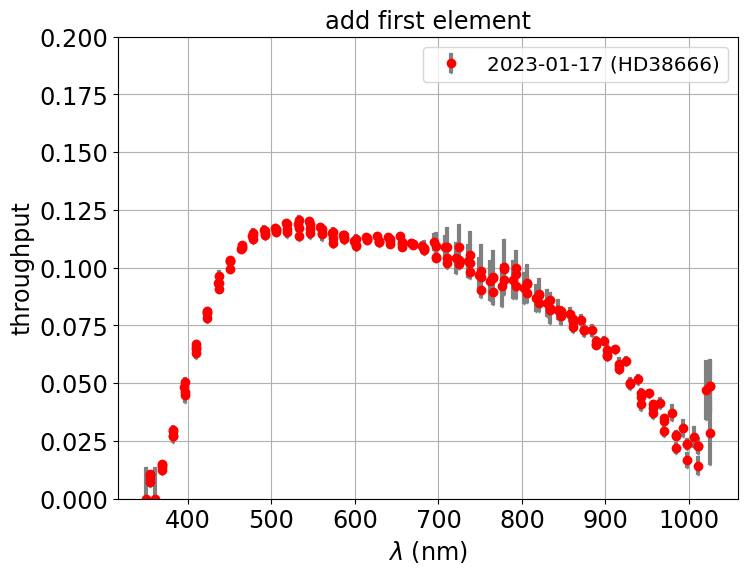

In [25]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="grey", elinewidth=3, capsize=0.5,label="2023-01-17 (HD38666)")
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0,0.2)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"add first element"
ax.set_title(title)

## Remove last elements

In [26]:
X = X[:-4]
Y = Y[:-4]
EY = EY[:-4]

Text(0.5, 1.0, 'remove last elements')

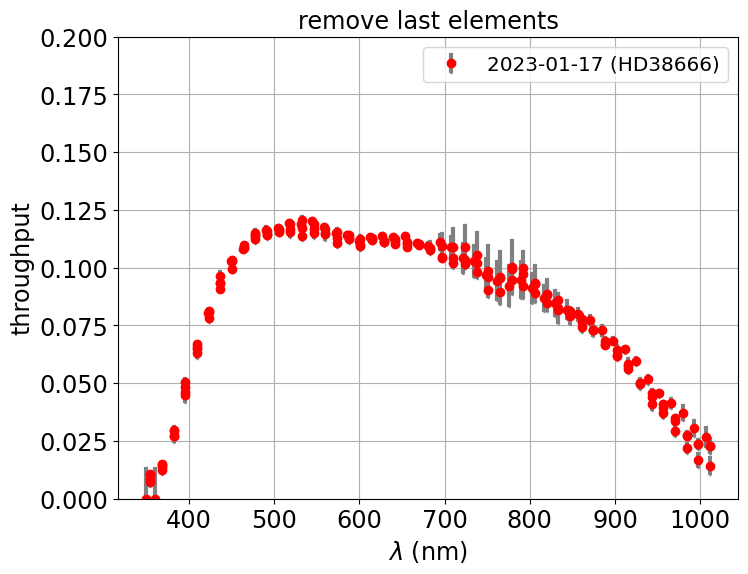

In [27]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="grey", elinewidth=3, capsize=0.5,label="2023-01-17 (HD38666)")
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0,0.2)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"remove last elements"
ax.set_title(title)

## Insert Last Element

In [28]:
X = np.append(X,1025)
Y = np.append(Y,0.01)
EY = np.append(EY,EY.max())


X = np.append(X,1050)
Y = np.append(Y,0.)
EY = np.append(EY,EY.max())

Text(0.5, 1.0, 'add last elements')

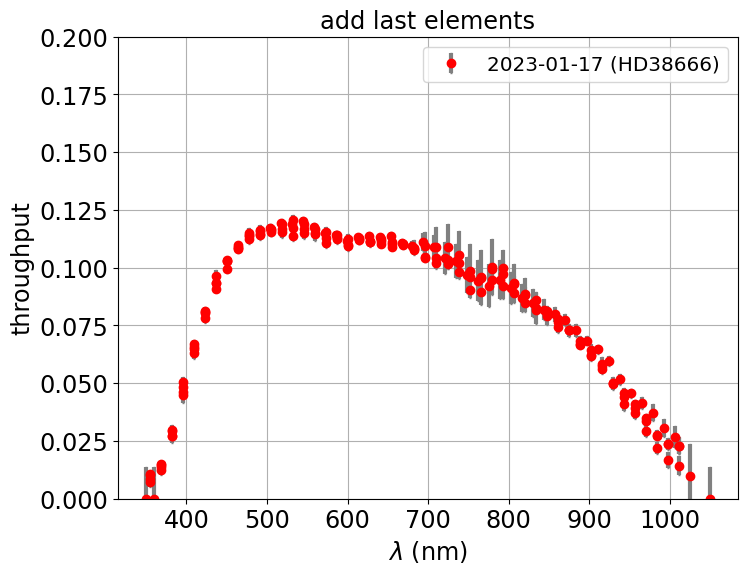

In [29]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="grey", elinewidth=3, capsize=0.5,label="2023-01-17 (HD38666)")
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0,0.2)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"add last elements"
ax.set_title(title)

Text(0.5, 1.0, 'Bouguer lines : Relative Optical Throughput for empty~holo4_003 at AUXTEL (2023-January-17-18)')

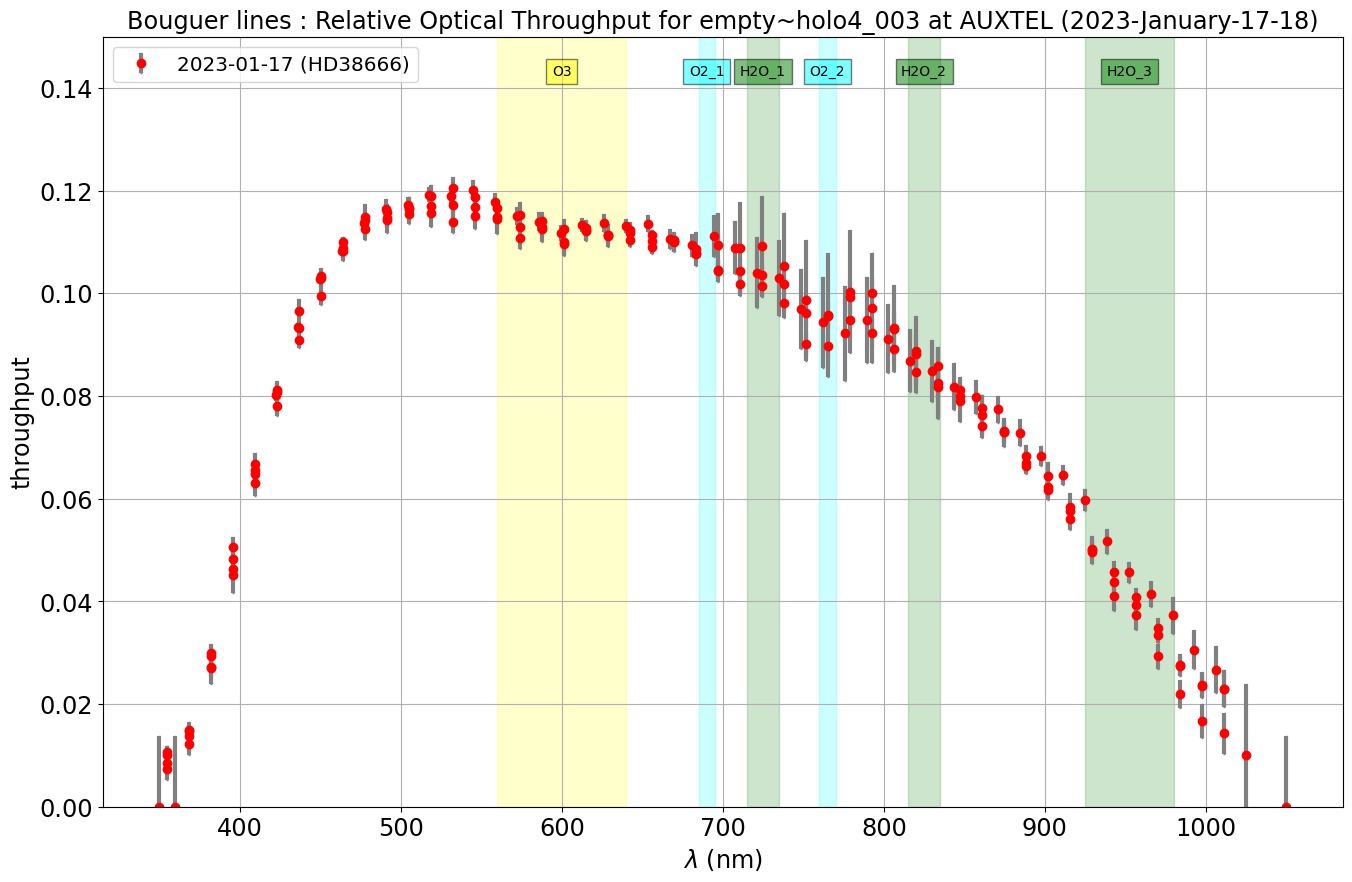

In [30]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="grey", elinewidth=3, capsize=1,label="2023-01-17 (HD38666)")
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)

the_ymin=0
the_ymax = 0.15
ax.set_ylim(the_ymin,the_ymax)

the_yscale = the_ymax-the_ymin

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    the_x = (val[0]+val[1])/2.
    the_y = the_ymax - 0.05* the_yscale
    rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
    ax.add_patch(rect)
    ax.text(the_x, the_y, key, horizontalalignment='center',bbox=dict(facecolor=absbands_colors[idx_abscolor], alpha=0.5))


ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput for {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)

# Fit a gaussian process

In [31]:
dfout = pd.DataFrame()
dfout["wavelength"]=X
dfout["throu"]=Y
dfout["errthrou"]=EY

In [32]:
!ls dataout/

MLfit_bouguer_linearfit-2023-01-17-rebin1-HD38666.csv
MLfit_bouguer_linearfit-2023-01-17-rebin2-HD38666.csv
MLfit_bouguer_linearfit-2023-01-18-rebin1-HD38666.csv
MLfit_bouguer_linearfit-2023-01-18-rebin2-HD38666.csv
MLfit_bouguer_linearfit-2023-01-19-rebin1-HD42525.csv
MLfit_bouguer_linearfit-2023-01-19-rebin2-HD42525.csv
MLfit_bouguer_linearfitsmoothGP-2023-January-17-18-mucol.csv
MLfit_bouguer_linearfitsmoothGPsmoothGP-absbadremoved-2023-January-17-18-mucol.csv


In [33]:
outputroot = outputfile_linearfit.split('-')[0]
if FLAG_POLAR:
    outputfile_linearfit=outputroot+f"_{DATE}-polar.csv"
else:
    outputfile_linearfit=outputroot+f"_{DATE}-{target}.csv" 

In [34]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 

# Fit gaussian

https://www.astroml.org/book_figures/chapter8/fig_gp_example.html


In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [36]:
kernel = kernels.RBF(0.5, (1, 150.0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=(EY) ** 2, random_state=0)

In [37]:
gp.fit(X[:, None], Y)

x = np.arange(350.,1050.,1.)

f, f_err = gp.predict(x[:, None], return_std=True)

In [38]:
# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gp.kernel_.theta)

best-fit theta = [4.76239926]


Text(0.5, 1.0, 'Gaussian fit of Throughput for empty~holo4_003 at AUXTEL (2023-January-17-18)')

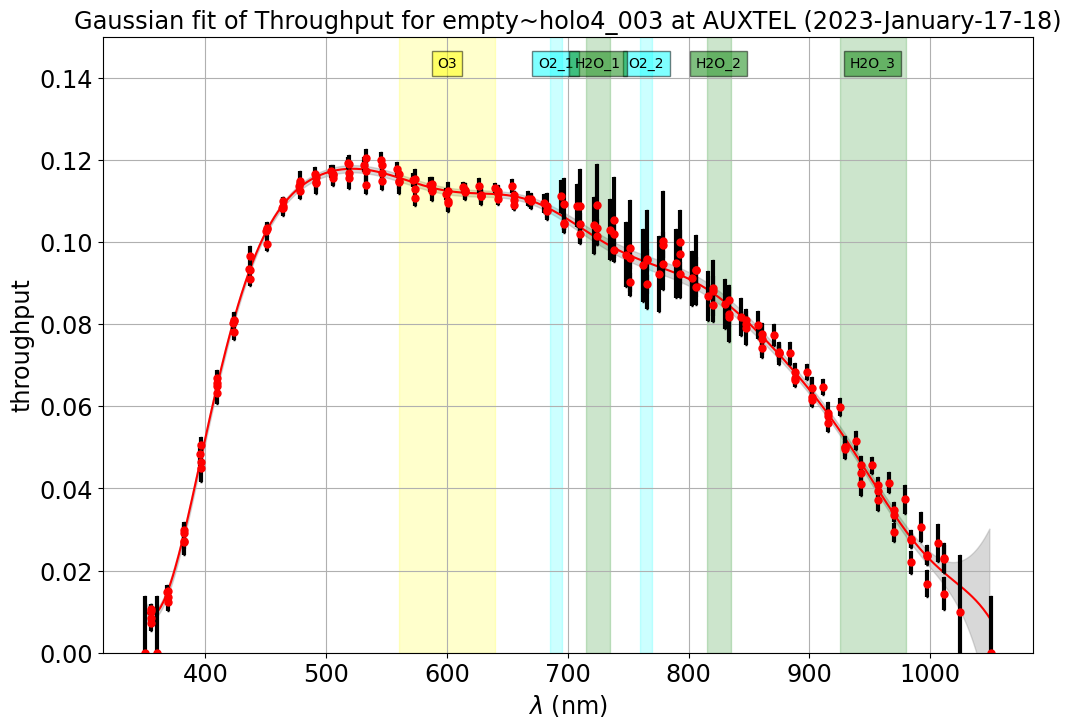

In [39]:
# third: plot a more constrained function with errors
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x, f, '-', color='red')
ax.fill_between(x, f - 2 * f_err, f + 2 * f_err, color='gray', alpha=0.3)
ax.errorbar(X, Y, EY, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1, ms=5)

the_ymin=0
the_ymax = 0.15
ax.set_ylim(the_ymin,the_ymax)

the_yscale = the_ymax-the_ymin

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    the_x = (val[0]+val[1])/2.
    the_y = the_ymax - 0.05* the_yscale
    rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
    ax.add_patch(rect)
    ax.text(the_x, the_y, key, horizontalalignment='center',bbox=dict(facecolor=absbands_colors[idx_abscolor], alpha=0.5))


ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Gaussian fit of Throughput for {FILTERTYPE} at {SITE} ({DATE})"
ax.grid()
ax.set_title(title)

## Save in a file

In [40]:
outputroot

'MLfit'

In [41]:
dfout = pd.DataFrame()
dfout["wavelength"]=x
dfout["throu"]=f
dfout["errthrou"]= f_err

In [42]:
outputroot = outputfile_linearfit.split('_')[0]
if FLAG_POLAR:
    outputfile_linearfit=outputroot+"smoothGP"+f"-{DATE}-polar.csv"
else:
    outputfile_linearfit=outputroot+"smoothGP"+f"-{DATE}-{target}.csv" 

In [43]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 

# Remove some bands

In [44]:
dict_bandindexes = {}
for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2]
    the_xmin = val[0]
    the_xmax = val[1]
    indexes = np.where(np.logical_and(X>=the_xmin,X<=the_xmax))[0]
    dict_bandindexes[key] = indexes

In [45]:
dict_bandindexes

{'O3': array([63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
        80, 81, 82, 83, 84, 85, 86]),
 'O2_1': array([102]),
 'O2_2': array([122, 123, 124, 125]),
 'H2O_1': array([110, 111, 112, 113, 114]),
 'H2O_2': array([138, 139, 140, 141, 142, 143, 144, 145]),
 'H2O_3': array([170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
        183, 184, 185, 186])}

In [46]:
all_indexes_to_remove = reduce(np.union1d, (dict_bandindexes['O3'],dict_bandindexes['O2_2'], dict_bandindexes['H2O_3']))

In [47]:
all_indexes_to_remove 

array([ 63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86, 122, 123,
       124, 125, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186])

In [48]:
Xcut = np.delete(X,all_indexes_to_remove)
Ycut = np.delete(Y,all_indexes_to_remove)
EYcut = np.delete(EY,all_indexes_to_remove)

In [49]:
kernel = kernels.RBF(0.5, (1, 150.0))
gpcut = GaussianProcessRegressor(kernel=kernel, alpha=(EYcut) ** 2, random_state=0)

In [50]:
gpcut.fit(Xcut[:, None], Ycut)

x = np.arange(350.,1050.,1.)

f, f_err = gpcut.predict(x[:, None], return_std=True)

In [51]:
# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gpcut.kernel_.theta)

best-fit theta = [4.79555268]


Text(0.5, 1.0, 'Gaussian fit of Throughput for empty~holo4_003 at AUXTEL (2023-January-17-18)')

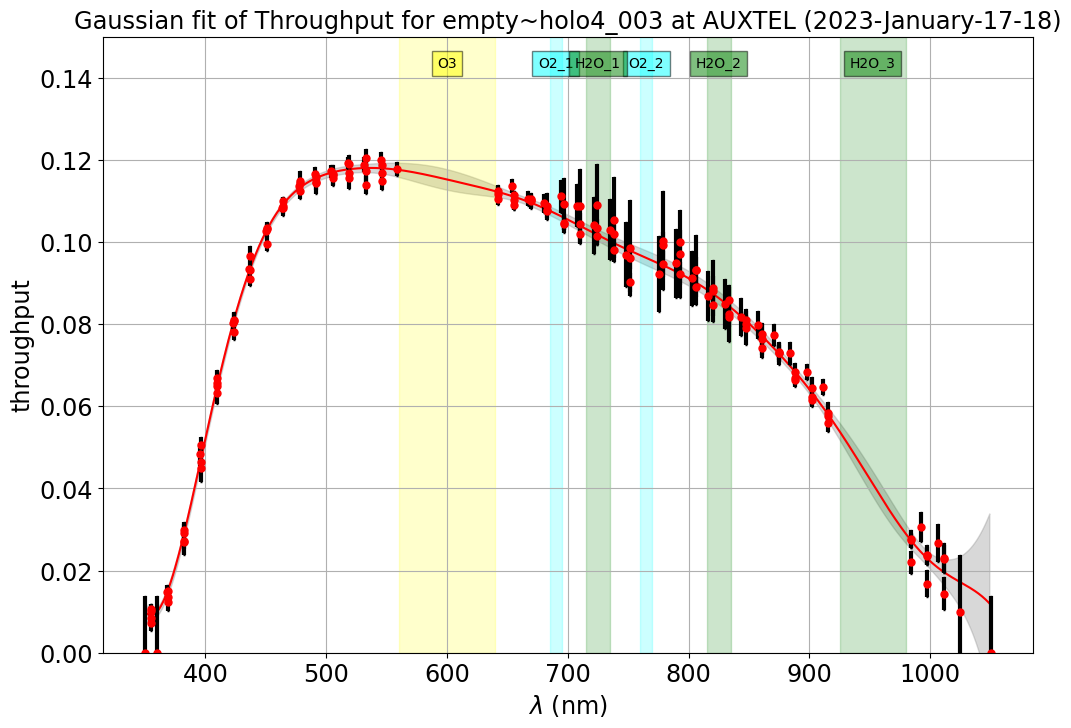

In [52]:
# third: plot a more constrained function with errors
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x, f, '-', color='red')
ax.fill_between(x, f - 2 * f_err, f + 2 * f_err, color='gray', alpha=0.3)
ax.errorbar(Xcut, Ycut, EYcut, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1, ms=5)

the_ymin=0
the_ymax = 0.15
ax.set_ylim(the_ymin,the_ymax)

the_yscale = the_ymax-the_ymin

for item in dict_absbands.items():
    key = item[0]
    val = item[1]
    idx_abscolor = val[2] 
    the_x = (val[0]+val[1])/2.
    the_y = the_ymax - 0.05* the_yscale
    rect = Rectangle((val[0],the_ymin),val[1]-val[0],the_ymax,linewidth=1,edgecolor=absbands_colors[idx_abscolor],facecolor=absbands_colors[idx_abscolor],alpha=0.2)
    ax.add_patch(rect)
    ax.text(the_x, the_y, key, horizontalalignment='center',bbox=dict(facecolor=absbands_colors[idx_abscolor], alpha=0.5))


ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Gaussian fit of Throughput for {FILTERTYPE} at {SITE} ({DATE})"
ax.grid()
ax.set_title(title)

### Save in a file

In [53]:
dfout = pd.DataFrame()
dfout["wavelength"]=x
dfout["throu"]=f
dfout["errthrou"]= f_err

In [54]:
outputroot = outputfile_linearfit.split('-')[0]
if FLAG_POLAR:
    outputfile_linearfit=outputroot+"smoothGP-absbadremoved"+f"-{DATE}-polar.csv"
else:
    outputfile_linearfit=outputroot+"smoothGP-absbadremoved"+f"-{DATE}-{target}.csv" 

In [55]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 